<a href="https://colab.research.google.com/github/taceroc/light_echo_modeling/blob/main/clena_spherical_blub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D


from astropy import units as u

import sys
sys.path.append('/content/drive/MyDrive/LE2023/dust/code')

import var_constants as vc
import dust_constants as dc
import fix_constants as fc
import scattering_function as sf
import size_dist as sd
import calculate_scattering_function as csf

from astropy import units as u
from scipy.special import erf
from scipy import integrate


plt.style.use('seaborn-v0_8-colorblind')

%config InlineBackend.figure_format='retina'

In [3]:
r0 = vc.r0ly
ct = vc.ct
x_p = np.linspace(-10,10,100)
y_p = np.linspace(-10,10,100)

x_p, y_p = np.meshgrid(x_p, y_p)
z_p = (x_p**2 + y_p**2 - ct**2) / (2 * ct)
z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]

<ipython-input-3-4e0255c19219>:8: RuntimeWarning: invalid value encountered in sqrt
  z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
<ipython-input-3-4e0255c19219>:9: RuntimeWarning: invalid value encountered in sqrt
  z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]


In [4]:
r0

6.52312

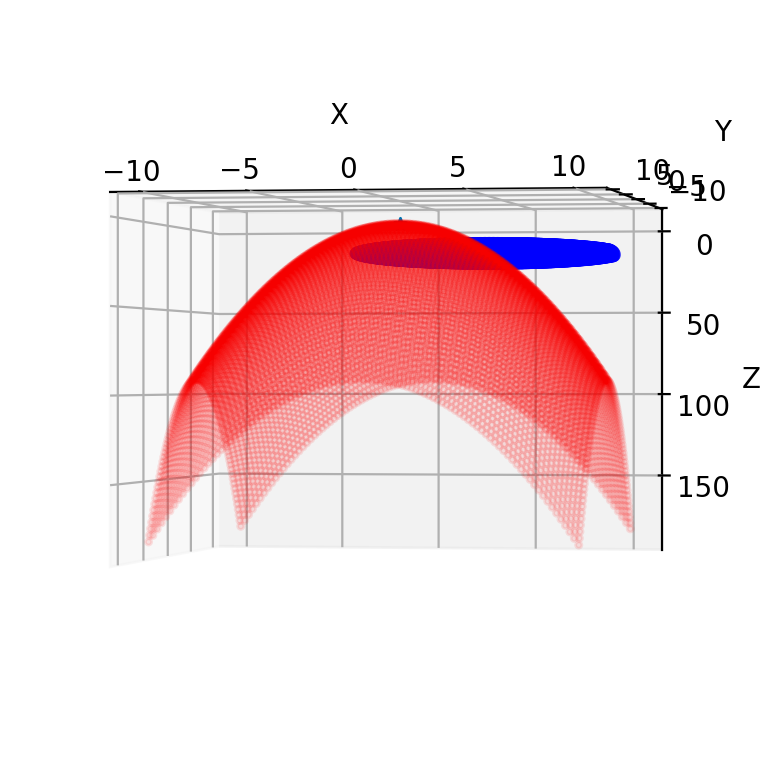

In [5]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(0,0,0, marker = "*")
ax.scatter(x_p, y_p, z_p, c='r', marker='.', alpha = 0.1)
ax.scatter(x_p, y_p, z_e, c='b', marker='.')
ax.scatter(x_p, y_p, z_e2, c='b', marker='.')

ax.scatter(x_p[43,70], y_p[43,70],z_p[43,70])


# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=-180, azim = -100)

# plt.title('Parametric Equation for a Sphere')
plt.show()

In [6]:
x_p = np.linspace(-10,10,100)
y_p = np.linspace(-10,10,100)

x_p, y_p = np.meshgrid(x_p, y_p)
z_p = (x_p**2 + y_p**2 - ct**2) / (2 * ct)
z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]

# Define the radius and center of the sphere
h = x_p[43, 70]
k = y_p[43, 70]
l = z_p[43, 70]
center = (h, k, l)

# Find points of intersection
intersection_points = []

for i in range(100):
  for j in range(100):
    x_par, y_par, z_par = x_p[i,j], y_p[i,j], z_p[i,j]

    # Check if the point is inside both the sphere and the paraboloid
    sphere_condition = ((x_par - center[0])**2 + (y_par - center[1])**2 + (z_par - center[2])**2) <= r0**2
    paraboloid_condition = (x_par**2 + y_par**2) <= (ct**2 + 2 * ct * z_par)

    if (sphere_condition and paraboloid_condition):
        intersection_points.append((x_par, y_par, z_par))



<ipython-input-6-3056123f8998>:6: RuntimeWarning: invalid value encountered in sqrt
  z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
<ipython-input-6-3056123f8998>:7: RuntimeWarning: invalid value encountered in sqrt
  z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]


In [7]:
x_inter = np.array([inter[0] for inter in intersection_points])
y_inter = np.array([inter[1] for inter in intersection_points])
z_inter = np.array([inter[2] for inter in intersection_points])

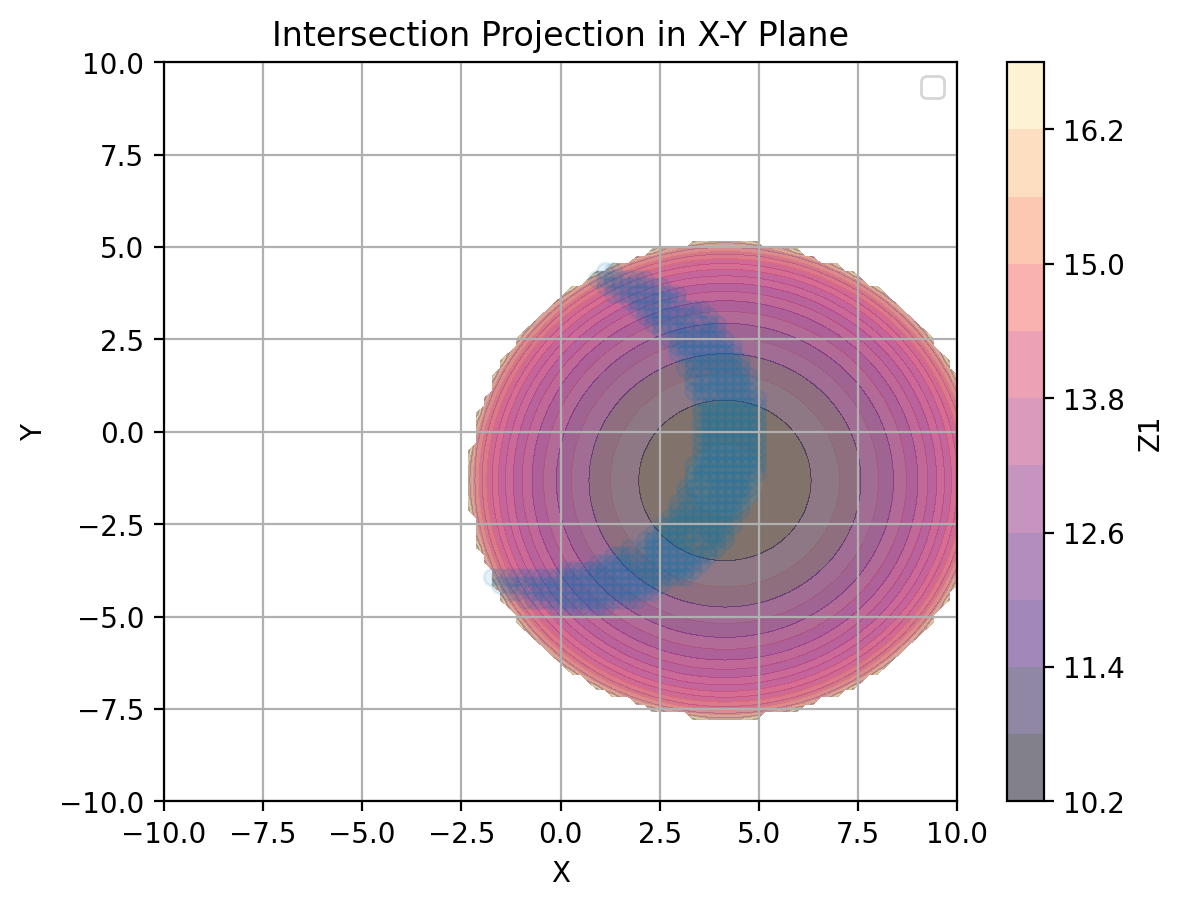

In [8]:
#  Create a contour plot in the X-Y plane (Z=0)
plt.figure()
plt.contourf(x_p, y_p, z_e, levels = 10, cmap='magma', alpha=0.5)
plt.contourf(x_p, y_p, z_e2, levels = 10, cmap='magma', alpha=0.5)

plt.colorbar(label='Z1')
# plt.contour(x_p, y_p, z_p, levels = 10, colors='red', linewidths=2, label='Intersection')
plt.scatter(x_inter, y_inter, alpha = 0.1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Intersection Projection in X-Y Plane')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [9]:
new_xs = np.arctan(x_inter / vc.d) * (180 / np.pi) * 3600
new_ys = np.arctan(y_inter / vc.d) * (180 / np.pi) * 3600

In [26]:
def surface_brightness(x_inter, y_inter, z_inter, dz0):

  Ir = 1.25*vc.L*0.5*vc.dt0 * fc.n_H * fc.c

  r = np.sqrt(x_inter**2 + y_inter**2 + z_inter**2)

  rhos = np.sqrt(2 * z_inter * vc.ct + (vc.ct)**2 )
  half_obs_thickness = np.sqrt( (vc.ct / rhos) ** 2 * dz0 ** 2 + ( (rhos * fc.c / 2 * vc.ct) + ( fc.c * vc.ct / 2 * rhos )) ** 2 * vc.dt0  ** 2 )
  rhodrho = rhos * half_obs_thickness

  ll = np.sqrt(x_inter**2 + y_inter**2 + (z_inter-vc.d)**2)
  # cossigma = (ll**2 + r**2 - d**2) / (2 * ll * r)
  cossigma = ((x_inter**2 + y_inter**2 + z_inter * (z_inter-vc.d)) / (r * ll))
  # print(cossigma)
  Fphi_arr = np.zeros(len(r))
  S = np.zeros(len(r))
  for ik, rm in enumerate(cossigma):
    if ((rm >= -1) and (rm <= 1)):
      ds, Scm = csf.main(rm, wave = 6.310E+02)
      # print(Scm)
      S[ik] = (Scm[0] * fc.pctoly**3) / (100 * fc.pctom )**3
    else:
      S[ik] = 0
      # print( Fphi_arr[ik])
  surface = np.zeros(len(r))
  # print(r.shape)
  for ff in range(len(x_inter)):
      # Fphi = scatter_phase_function(scatter_angle = delta)
      surface[ff] = Ir * S[ff] * dz0 / ( 4 * np.pi * r[ff] * rhodrho[ff] )



  return surface

# Draw of what I want to do

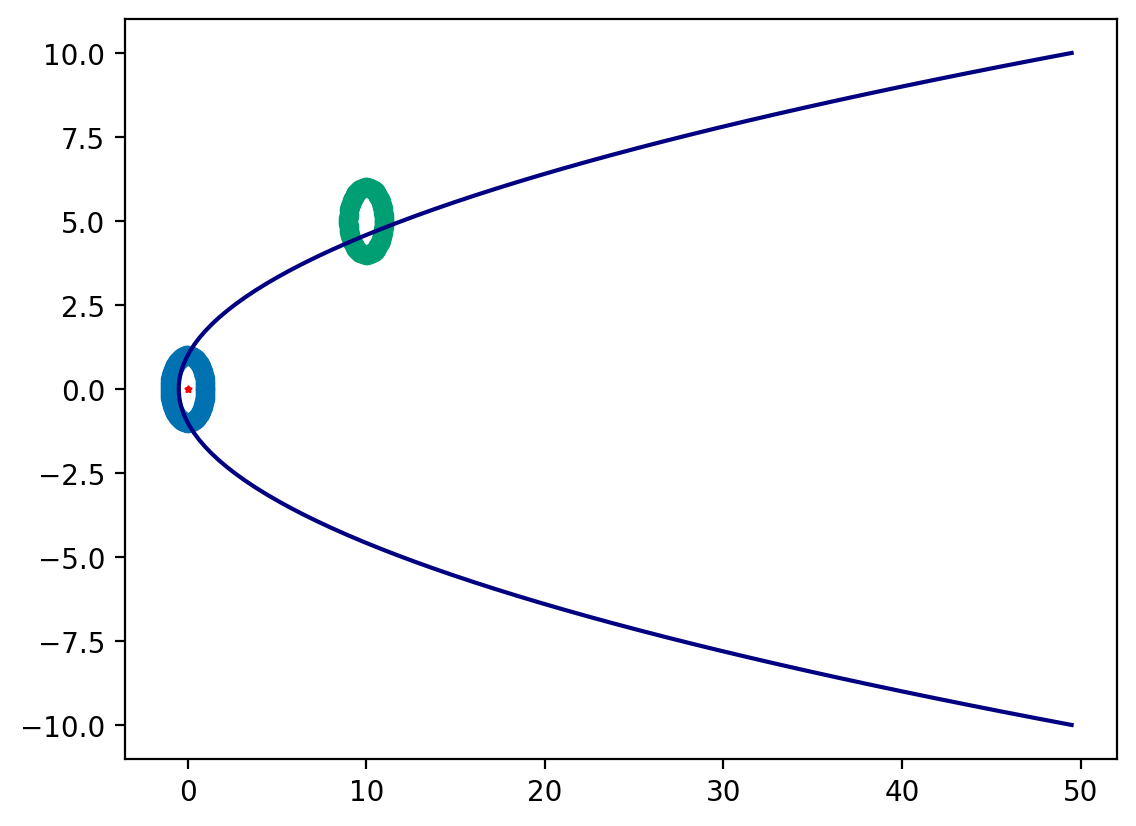

In [11]:
rr = 1
theta = np.linspace(0, 2*np.pi, 100)
plt.scatter(rr*np.cos(theta), rr*np.sin(theta))
plt.scatter(0,0, marker = "*", s = 4, color = "red")
plt.scatter(rr*np.cos(theta) +10, rr*np.sin(theta) + 5 )
ct = 1
# z = np.linspace(-0.999/2,17,100)
x = np.linspace(-10,10,100)
z = (x**2 - ct**2) / (2 * ct)
plt.plot(z, x, c = "navy", label = "ct=1");

In [12]:
x_p = np.linspace(-10,10,100)
y_p = np.linspace(-10,10,100)

x_p, y_p = np.meshgrid(x_p, y_p)
z_p = (x_p**2 + y_p**2 - ct**2) / (2 * ct)
# z_p = np.zeros((len(x_p), len(y_p)))
# z = (x**2 - y**2 - ct**2) / (2 * ct)

In [13]:
z_p.shape

(100, 100)

Text(0.5, 1.0, 'x0 = 4.14, y0 = -1.31, z0 = 8.94')

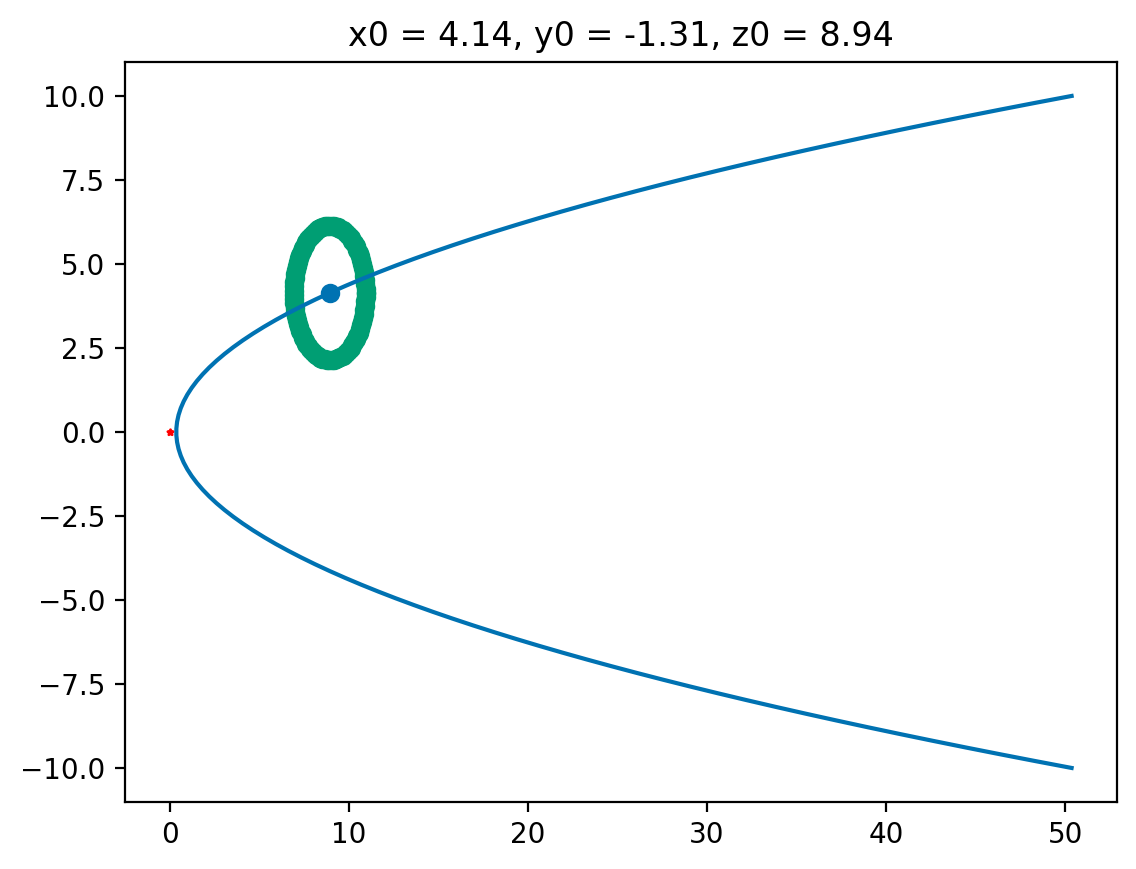

In [14]:
plt.plot(z_p[43,:], x_p[43, :])
plt.scatter(0,0, marker = "*", s = 4, color = "red")
theta = np.linspace(0, 2*np.pi, 100)
plt.scatter(z_p[43,70], x_p[43,70])
rr = 2
plt.scatter(rr*np.cos(theta) + z_p[43,70] , rr*np.sin(theta) + x_p[43,70])
plt.title("x0 = %.2f, y0 = %.2f, z0 = %.2f"%(x_p[43, 70], y_p[43, 70], z_p[43, 70]))



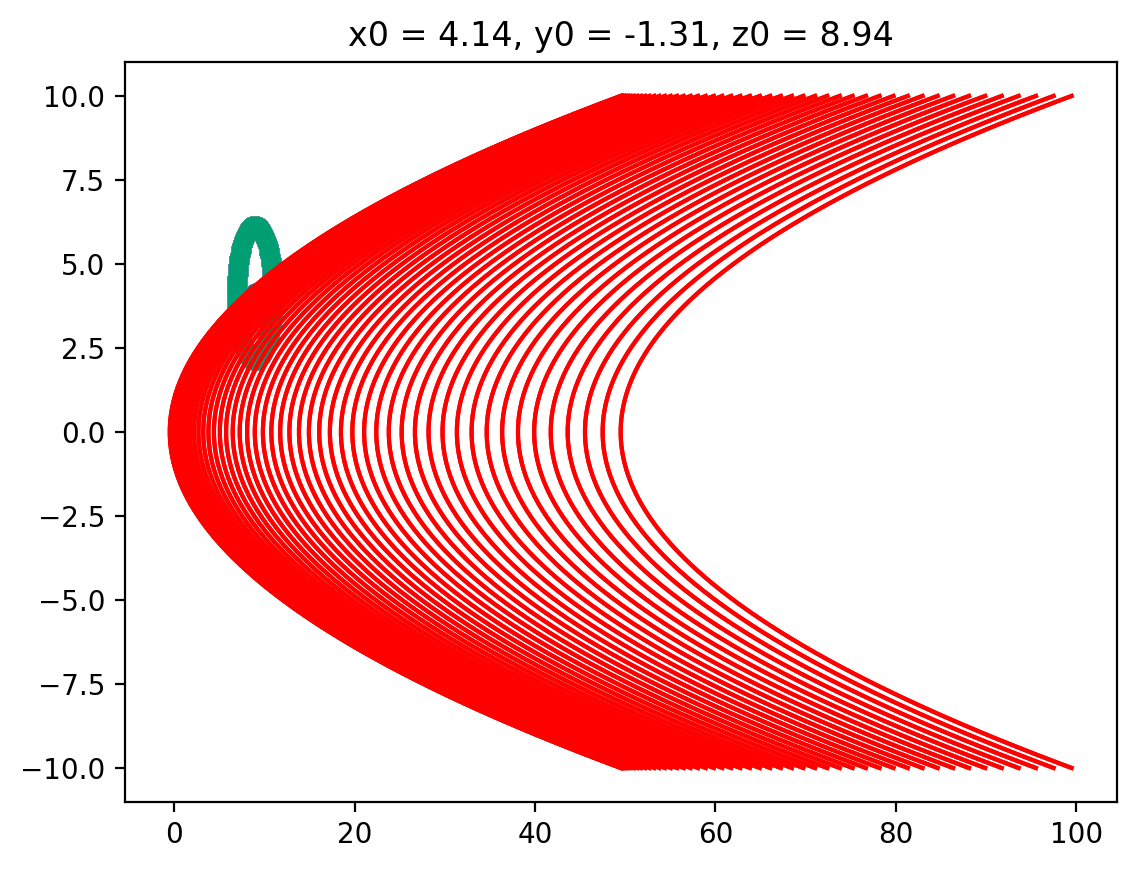

In [15]:
for i in range(100):
  plt.plot(z_p[i,:], x_p[i, :], color ="red" )
  plt.scatter(0,0, marker = "*", s = 4, color = "red")
  theta = np.linspace(0, 2*np.pi, 100)
  plt.scatter(z_p[43,70], x_p[43,70])
  plt.title("x0 = %.2f, y0 = %.2f, z0 = %.2f"%(x_p[43, 70], y_p[43, 70], z_p[43, 70]))
  rr = 2
  plt.scatter(rr*np.cos(theta) + z_p[43,70] , rr*np.sin(theta) + x_p[43,70])

# Simulate firs the shape

In [16]:
# r0 = 8
x_p = np.linspace(-10,10,100)
y_p = np.linspace(-10,10,100)

x_p, y_p = np.meshgrid(x_p, y_p)
z_p = (x_p**2 + y_p**2 - ct**2) / (2 * ct)
z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]



<ipython-input-16-7a9517b0c46d>:7: RuntimeWarning: invalid value encountered in sqrt
  z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
<ipython-input-16-7a9517b0c46d>:8: RuntimeWarning: invalid value encountered in sqrt
  z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]


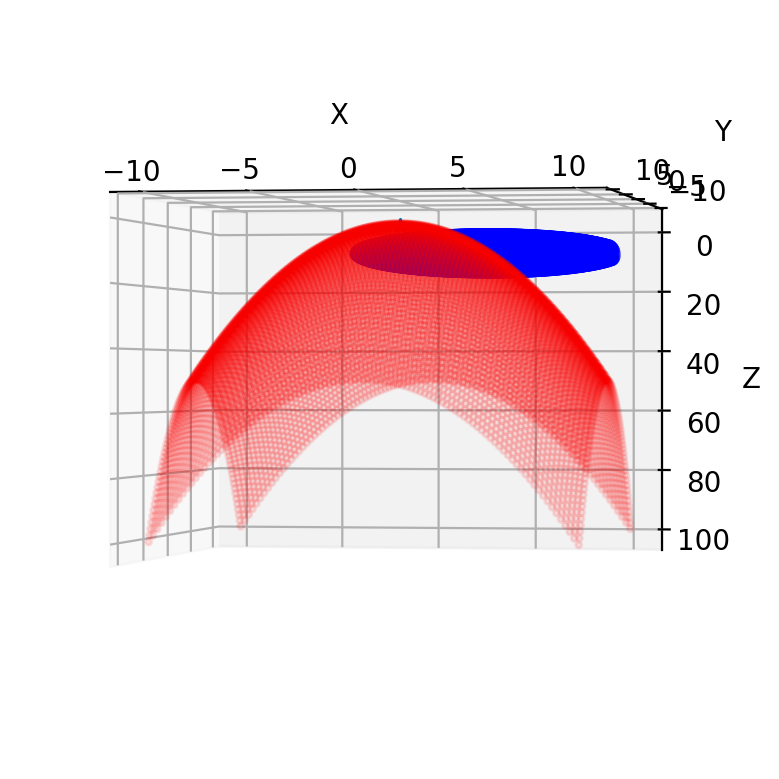

In [17]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(0,0,0, marker = "*")
ax.scatter(x_p, y_p, z_p, c='r', marker='.', alpha = 0.1)
ax.scatter(x_p, y_p, z_e, c='b', marker='.')
ax.scatter(x_p, y_p, z_e2, c='b', marker='.')


ax.scatter(x_p[43,70], y_p[43,70],z_p[43,70])


# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=-180, azim = -100)

# plt.title('Parametric Equation for a Sphere')
plt.show()


In [18]:
x.shape

(100,)

## Determine the intersection points

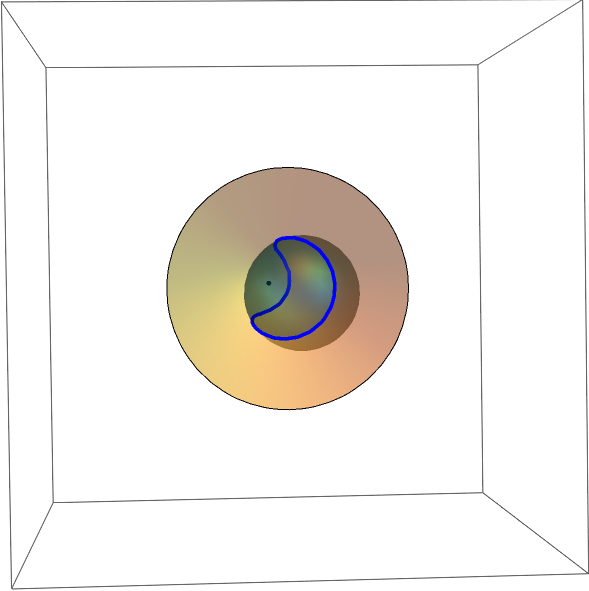

All points inside the "crescent" form the LE. The sphere is thick

In [19]:

x_p = np.linspace(-10,10,100)
y_p = np.linspace(-10,10,100)

x_p, y_p = np.meshgrid(x_p, y_p)
z_p = (x_p**2 + y_p**2 - vc.ct**2) / (2 * vc.ct)
z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]

# Define the radius and center of the sphere
h = x_p[43, 70]
k = y_p[43, 70]
l = z_p[43, 70]
center = (h, k, l)

# Find points of intersection
intersection_points = []

for i in range(100):
  for j in range(100):
    x_par, y_par, z_par = x_p[i,j], y_p[i,j], z_p[i,j]

    # Check if the point is inside both the sphere and the paraboloid
    sphere_condition = ((x_par - center[0])**2 + (y_par - center[1])**2 + (z_par - center[2])**2) <= r0**2
    paraboloid_condition = (x_par**2 + y_par**2) <= (vc.ct**2 + 2 * vc.ct * z_par)

    if (sphere_condition and paraboloid_condition):
        intersection_points.append((x_par, y_par, z_par))



<ipython-input-19-eebc1dbdc47a>:6: RuntimeWarning: invalid value encountered in sqrt
  z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
<ipython-input-19-eebc1dbdc47a>:7: RuntimeWarning: invalid value encountered in sqrt
  z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]


In [20]:
np.array(intersection_points).shape

(435, 3)

In [21]:
x_inter = np.array([inter[0] for inter in intersection_points])
y_inter = np.array([inter[1] for inter in intersection_points])
z_inter = np.array([inter[2] for inter in intersection_points])

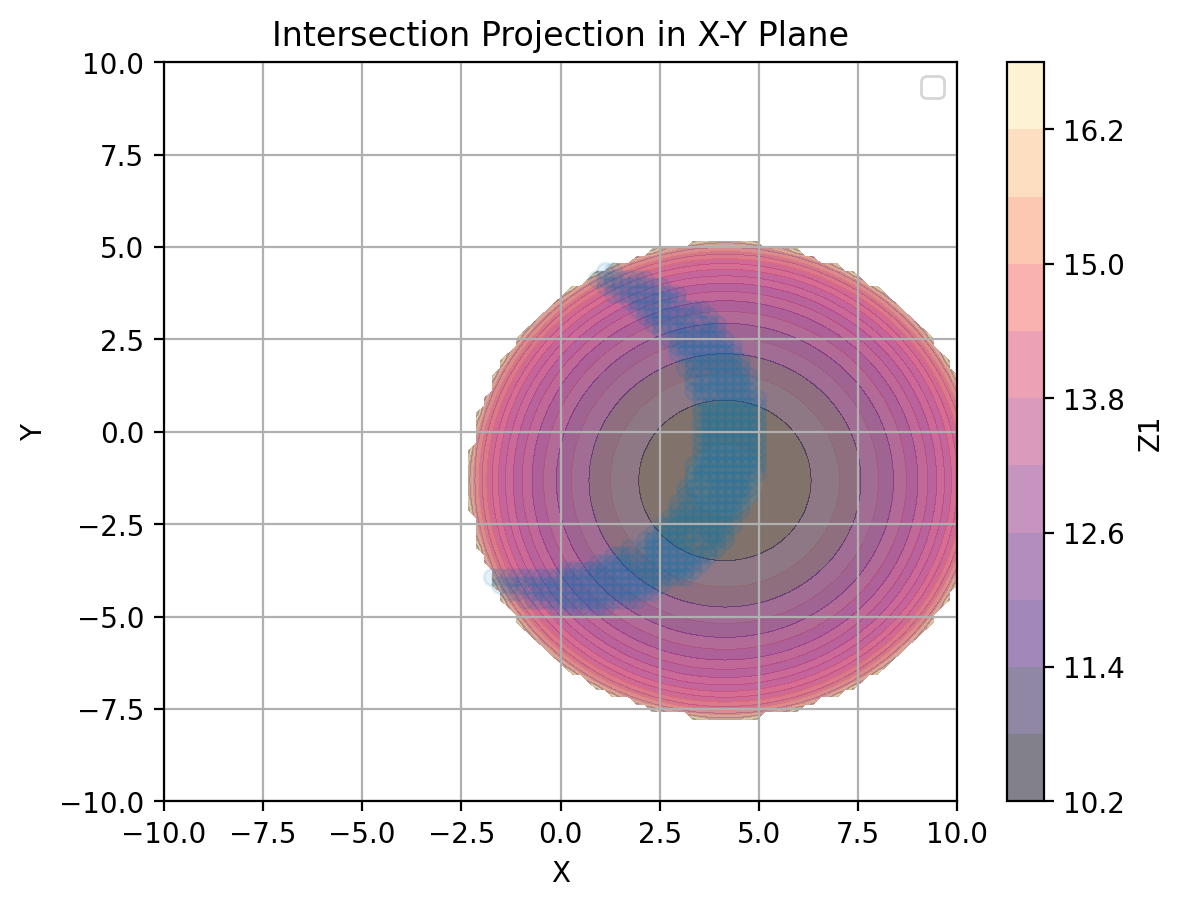

In [22]:
# Create a contour plot in the X-Y plane (Z=0)
plt.figure()
plt.contourf(x_p, y_p, z_e, levels = 10, cmap='magma', alpha=0.5)
plt.contourf(x_p, y_p, z_e2, levels = 10, cmap='magma', alpha=0.5)

plt.colorbar(label='Z1')
# plt.contour(x_p, y_p, z_p, levels = 10, colors='red', linewidths=2, label='Intersection')
plt.scatter(x_inter, y_inter, alpha = 0.1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Intersection Projection in X-Y Plane')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [23]:
new_xs = np.arctan(x_inter / vc.d) * (180 / np.pi) * 3600
new_ys = np.arctan(y_inter / vc.d) * (180 / np.pi) * 3600

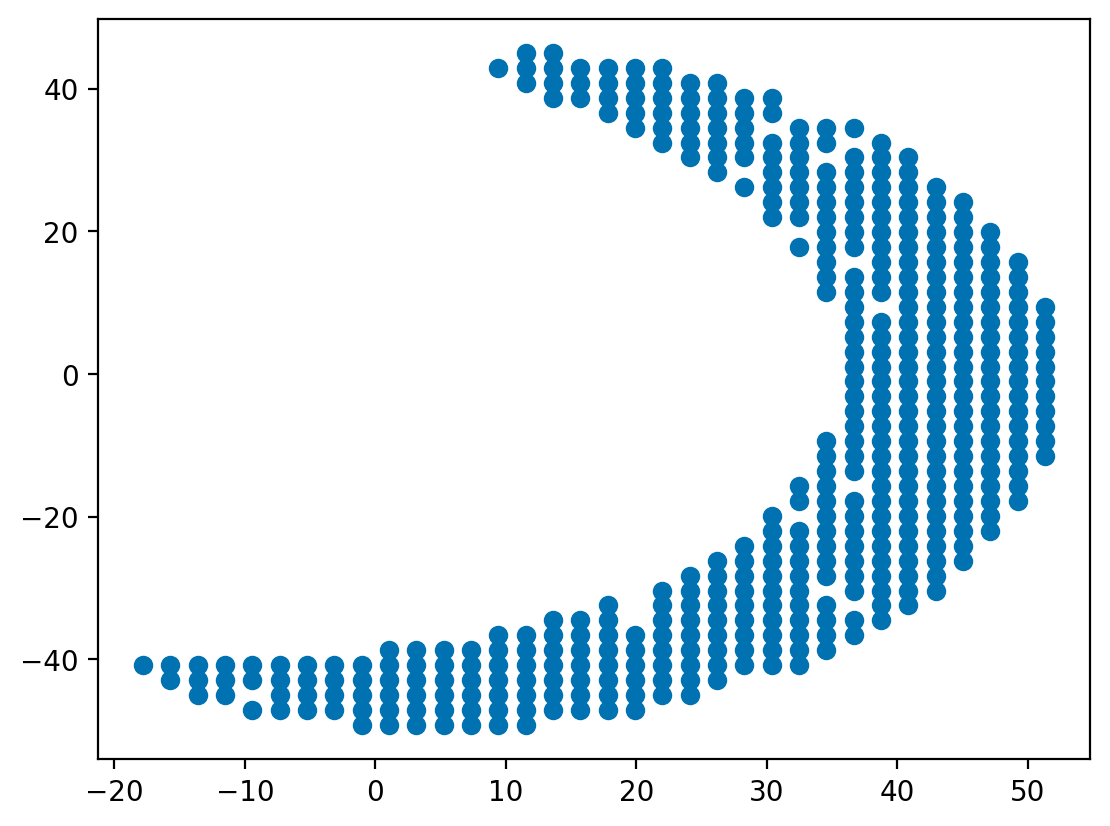

In [24]:
plt.scatter(new_xs, new_ys)

## Determine dust distribution and surface brightness

In [27]:
# data_cube = dust(x_inter, n_h = n)
dz0 = np.abs(z_inter.min()-z_inter.max())
surface = surface_brightness(x_inter, y_inter, z_inter, dz0)

[6.416509620756207e+21]
[6.416509620756207e+21]
[6.416521042934686e+21]
[6.416543645208006e+21]
[6.41657695610125e+21]
[6.416620298907898e+21]
[6.416672825053491e+21]
[6.416353349350854e+21]
[6.416302158925184e+21]
[6.416262732837923e+21]
[6.41623593958993e+21]
[6.416222386644033e+21]
[6.416222386644033e+21]
[6.41623593958993e+21]
[6.416262732837923e+21]
[6.416302158925184e+21]
[6.416353349350854e+21]
[6.416415220885069e+21]
[6.416486529963114e+21]
[6.416565930363976e+21]
[6.416652029648536e+21]
[6.416743440606602e+21]
[6.416208727855803e+21]
[6.416124481339112e+21]
[6.415990249388103e+21]
[6.415943250324264e+21]
[6.415911254059253e+21]
[6.415895051779568e+21]
[6.415895051779568e+21]
[6.415911254059253e+21]
[6.415943250324264e+21]
[6.415990249388103e+21]
[6.416051125074639e+21]
[6.416124481339112e+21]
[6.416208727855803e+21]
[6.416302158925184e+21]
[6.416403029159624e+21]
[6.416509620756207e+21]
[6.416620298907898e+21]
[6.416733553694441e+21]
[6.41600565689847e+21]
[6.415895051779568e+

## Plot of initial LE, no including the thickness due to the duration of the flash

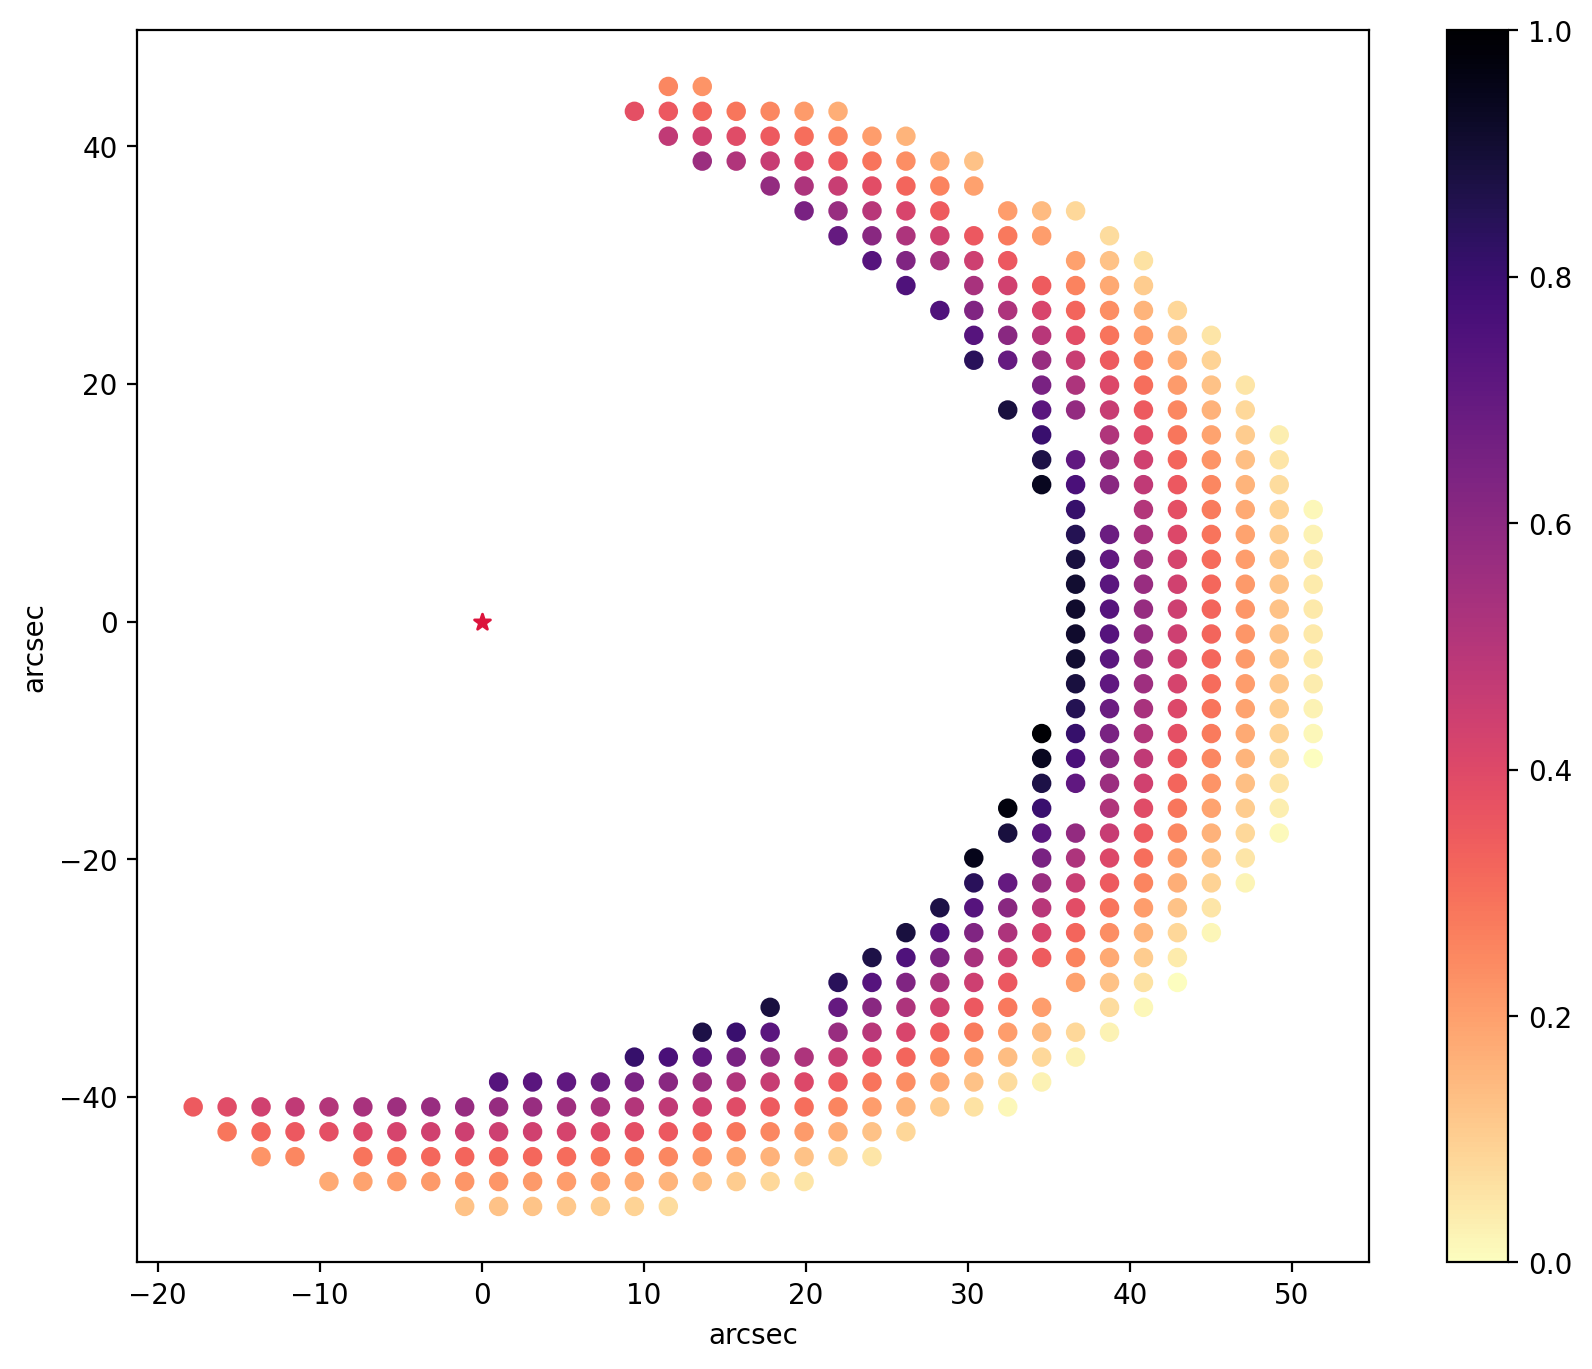

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
# cmap = matplotlib.colormaps.get_cmap('magma_r')
# normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
ax.scatter(0, 0, marker = "*", color = "crimson")
cbarr = ax.scatter(new_xs, new_ys, c=surface_300_norm, cmap = "magma_r")
ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)
plt.colorbar(cbarr)

## Include thickness: I think this is wrong!

In [32]:
def rinout(y_inter, x_inter, z_inter, dz0):
  phis = np.arctan2(y_inter, x_inter)
  # zz = (l - ct) + np.sqrt(r0**2 - h**2 - k**2 + 2 * (x_inter * h - y_inter * k - l * ct))
  rhos = np.sqrt(2 * z_inter * vc.ct + (vc.ct)**2 )
  half_obs_thickness = np.sqrt( (vc.ct / rhos) ** 2 * dz0 ** 2 + ( (rhos * fc.c / 2 * ct) + ( fc.c * vc.ct / 2 * rhos )) ** 2 * vc.dt0  ** 2 ) / 2
  # -- include the thickness in xy plane
  r_le_out = rhos + half_obs_thickness
  # -- degree to arcseconds
  r_le_out = np.arctan(r_le_out / vc.d) * (180 / np.pi) * 3600
  r_le_in = rhos - half_obs_thickness
  r_le_in = np.arctan(r_le_in / vc.d) * (180 / np.pi) * 3600


  return phis, r_le_out, r_le_in, rhos, half_obs_thickness

In [33]:
dz0 = np.abs(z_inter.min()-z_inter.max())
phis, r_le_out, r_le_in, rhos, half_obs_thickness = rinout(y_inter, x_inter, z_inter, dz0)

In [34]:
half_obs_thickness.shape

(435,)

In [35]:
def final_xy_projected(phis, r_le_out, r_le_in):
    radii_p = [r_le_out, r_le_in]
    # xs_p = np.outer(radii_p, np.cos(phis)) - act
    xs_p = np.concatenate([radii_p[0] * np.cos(phis), radii_p[1] * np.cos(phis)]).reshape(2, len(phis))
    ys_p = np.concatenate([radii_p[0] * np.sin(phis), radii_p[1] * np.sin(phis)]).reshape(2, len(phis))
    # ys_p = np.outer(radii_p, np.sin(phis))
    # print(xs_p.shape)

    new_xs = xs_p.reshape(1,2,len(phis))
    new_ys = ys_p.reshape(1,2,len(phis))

    return new_xs, new_ys

In [36]:
new_xs_proj, new_ys_proj = final_xy_projected(phis, r_le_out, r_le_in)

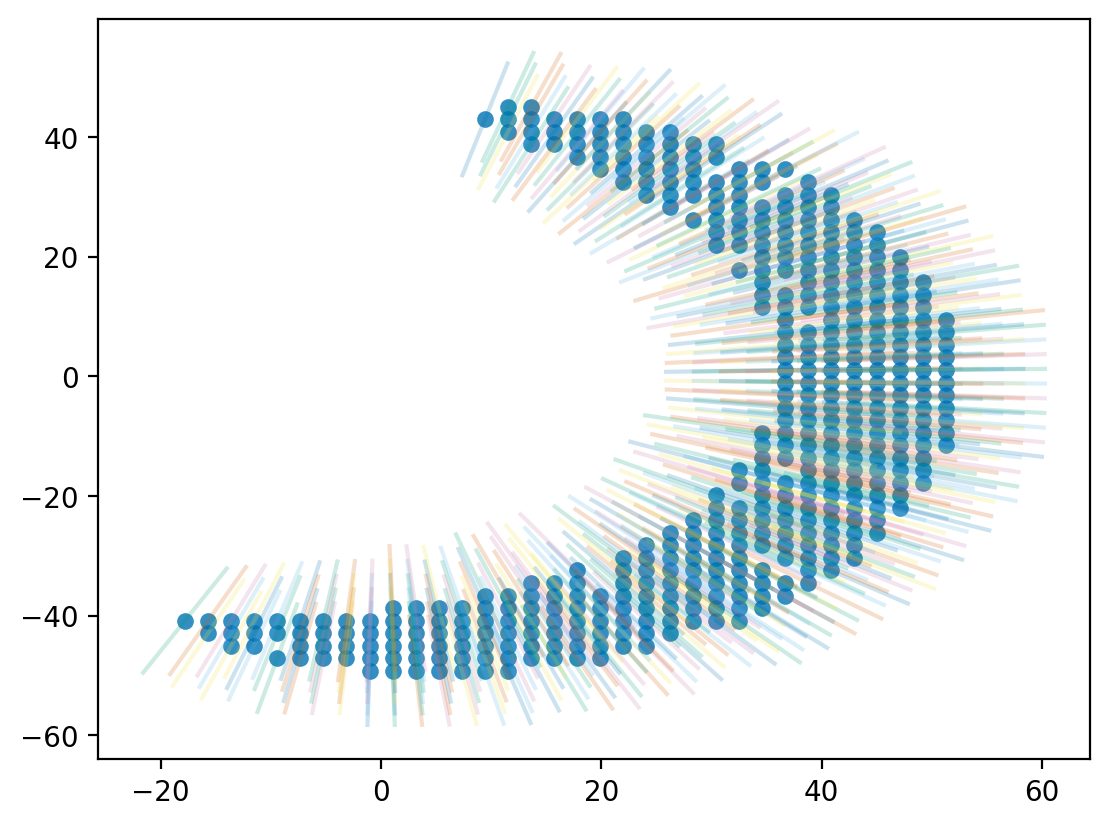

In [37]:
plt.plot(new_xs_proj[0,:,:], new_ys_proj[0,:,:], alpha = 0.2)
plt.scatter(new_xs, new_ys, alpha = 0.8, linewidth = 0)

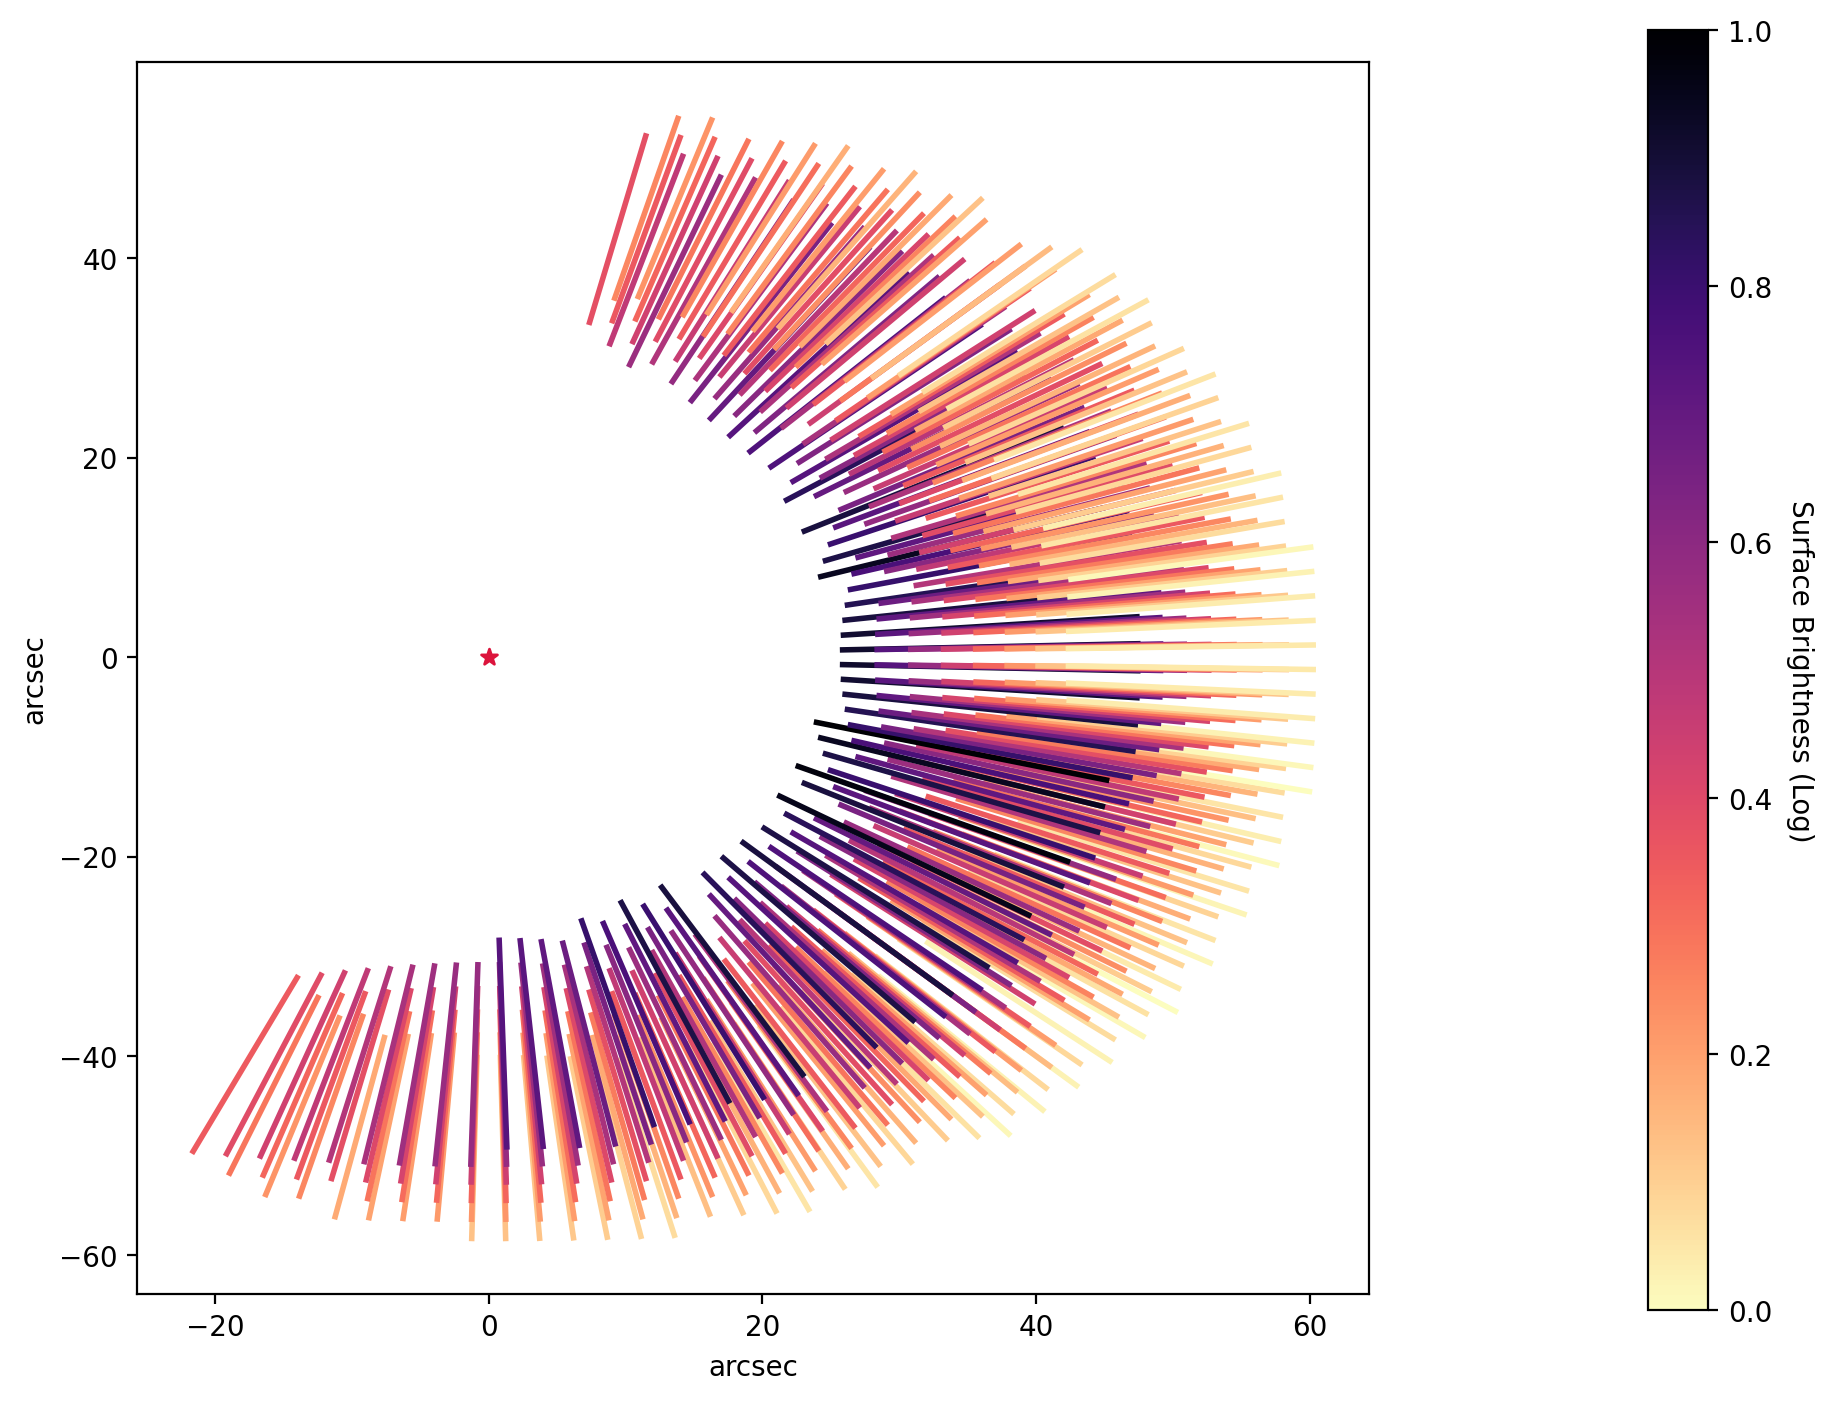

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
ax.scatter(0, 0, marker = "*", color = "crimson")

for k in range(len(surface)):
  cbar = ax.plot(new_xs_proj[0, :, k], new_ys_proj[0, :, k], color=cmap(normalize(surface_300_norm[k])), linewidth = 2)
# cbarr = ax.plot(new_xs_proj[0,:,:], new_ys_proj[0,:,:], c=surface_300_norm, cmap = "magma_r")
ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)


cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])
cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)

# Try two blub

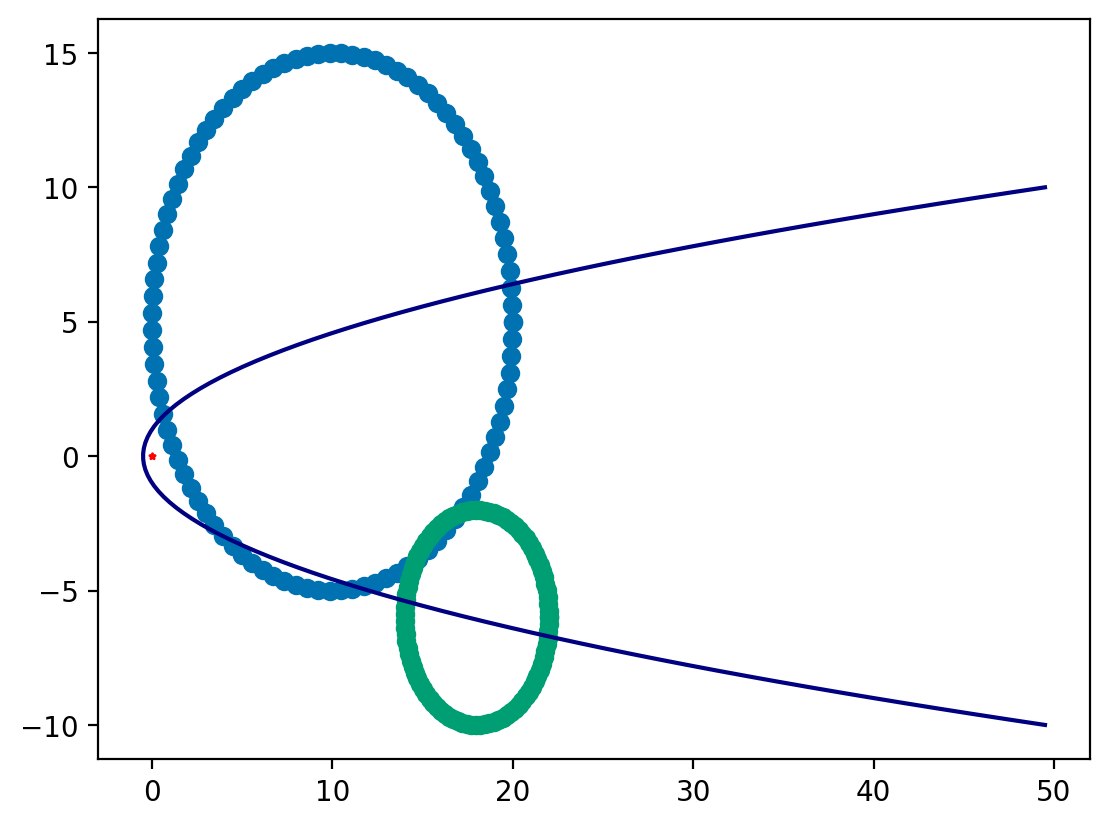

In [39]:
rr = 10
rr1 = 4
theta = np.linspace(0, 2*np.pi, 100)
plt.scatter(0,0, marker = "*", s = 4, color = "red")
plt.scatter(rr*np.cos(theta) +10, rr*np.sin(theta) + 5 )
plt.scatter(rr1*np.cos(theta) + 18, rr1*np.sin(theta) - 6 )

ct = 1
# z = np.linspace(-0.999/2,17,100)
x = np.linspace(-10,10,100)
z = (x**2 - ct**2) / (2 * ct)
plt.plot(z, x, c = "navy", label = "ct=1");

In [40]:
r01 = 10
r02 = 4
x_p = np.linspace(-10,10,100)
y_p = np.linspace(-10,10,100)

x_p, y_p = np.meshgrid(x_p, y_p)
z_p = (x_p**2 + y_p**2 - ct**2) / (2 * ct)
z_e0 = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
z_e02 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]

z_e1 = np.sqrt(r0**2 - (x_p-x_p[10, 33])**2 - (y_p-y_p[10, 33])**2) + z_p[10, 33]
z_e12 = -np.sqrt(r0**2 - (x_p-x_p[10, 33])**2 - (y_p-y_p[10, 33])**2) + z_p[10, 33]

<ipython-input-40-d72a043387d1>:8: RuntimeWarning: invalid value encountered in sqrt
  z_e0 = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
<ipython-input-40-d72a043387d1>:9: RuntimeWarning: invalid value encountered in sqrt
  z_e02 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
<ipython-input-40-d72a043387d1>:11: RuntimeWarning: invalid value encountered in sqrt
  z_e1 = np.sqrt(r0**2 - (x_p-x_p[10, 33])**2 - (y_p-y_p[10, 33])**2) + z_p[10, 33]
<ipython-input-40-d72a043387d1>:12: RuntimeWarning: invalid value encountered in sqrt
  z_e12 = -np.sqrt(r0**2 - (x_p-x_p[10, 33])**2 - (y_p-y_p[10, 33])**2) + z_p[10, 33]


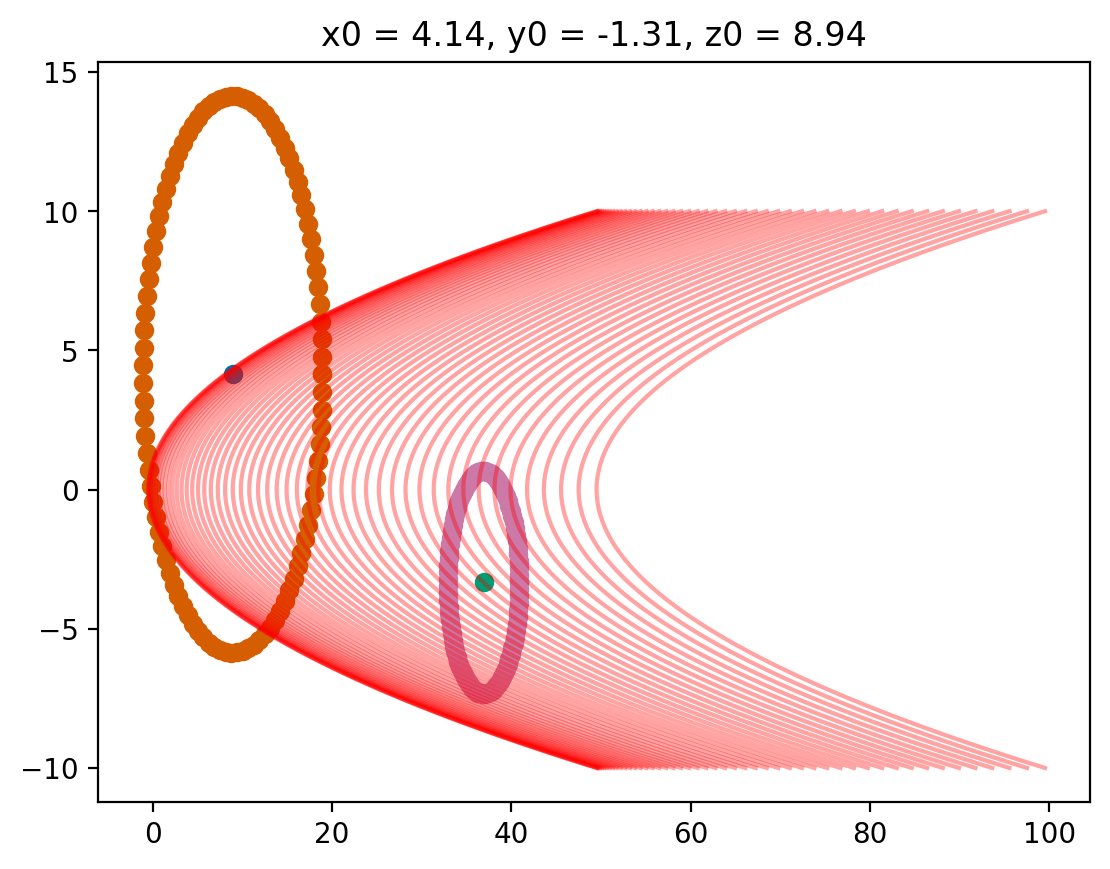

In [41]:
# theta = np.linspace(0, 2*np.pi, 100)
# plt.scatter(0,0, marker = "*", s = 4, color = "red")
# plt.scatter(r01*np.cos(theta) + x_p[43, 70], r01*np.sin(theta) + y_p[43, 70] )
# plt.scatter(r02*np.cos(theta) + x_p[10, 33], rr1*np.sin(theta) - y_p[10, 33] )
# plt.plot(z_p[10,:], x_p[10,:])
# plt.plot(z_p[43,:], x_p[43,:])

theta = np.linspace(0, 2*np.pi, 100)
plt.scatter(0,0, marker = "*", s = 4, color = "red")
plt.scatter(z_p[43,70], x_p[43,70])
plt.scatter(z_p[10,33], x_p[10,33])

plt.title("x0 = %.2f, y0 = %.2f, z0 = %.2f"%(x_p[43, 70], y_p[43, 70], z_p[43, 70]))
rr = 2
plt.scatter(r01*np.cos(theta) + z_p[43,70] , r01*np.sin(theta) + x_p[43,70])
plt.scatter(r02*np.cos(theta) + z_p[10,33] , r02*np.sin(theta) + x_p[10,33])

for i in range(100):
  plt.plot(z_p[i,:], x_p[i, :], color ="red", alpha = 0.2)




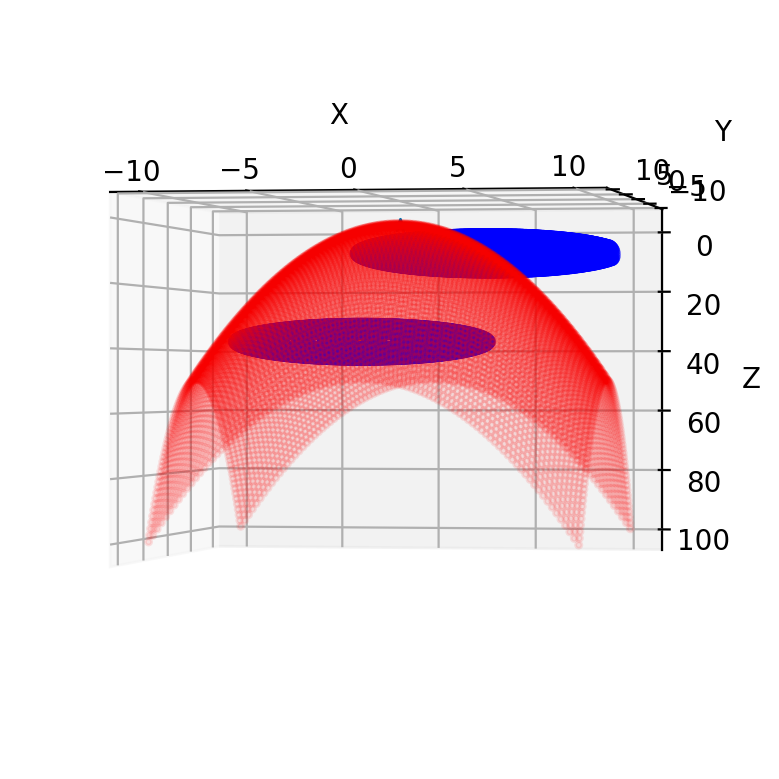

In [42]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(0,0,0, marker = "*")
ax.scatter(x_p, y_p, z_p, c='r', marker='.', alpha = 0.1)
ax.scatter(x_p, y_p, z_e0, c='b', marker='.')
ax.scatter(x_p, y_p, z_e02, c='b', marker='.')
ax.scatter(x_p, y_p, z_e1, c='b', marker='.')
ax.scatter(x_p, y_p, z_e12, c='b', marker='.')


ax.scatter(x_p[43,70], y_p[43,70],z_p[43,70])
ax.scatter(x_p[10,33], y_p[10,33],z_p[10,33])

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=-180, azim = -100)

# plt.title('Parametric Equation for a Sphere')
plt.show()

In [44]:



x_p = np.linspace(-10,10,100)
y_p = np.linspace(-10,10,100)

x_p, y_p = np.meshgrid(x_p, y_p)
z_p = (x_p**2 + y_p**2 - vc.ct**2) / (2 * vc.ct)
z_e0 = np.sqrt(r01**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
z_e02 = -np.sqrt(r01**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]


# Define the radius and center of the sphere
h = x_p[43, 70]
k = y_p[43, 70]
l = z_p[43, 70]
center = (h, k, l)

# Find points of intersection
intersection_points_1 = []

for i in range(100):
  for j in range(100):
    x_par, y_par, z_par = x_p[i,j], y_p[i,j], z_p[i,j]

    # Check if the point is inside both the sphere and the paraboloid
    sphere_condition = ((x_par - center[0])**2 + (y_par - center[1])**2 + (z_par - center[2])**2) <= r01**2
    paraboloid_condition = (x_par**2 + y_par**2) <= (ct**2 + 2 * ct * z_par)

    if (sphere_condition and paraboloid_condition):
        intersection_points_1.append((x_par, y_par, z_par))



<ipython-input-44-be4b4d6d0e2d>:6: RuntimeWarning: invalid value encountered in sqrt
  z_e0 = np.sqrt(r01**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
<ipython-input-44-be4b4d6d0e2d>:7: RuntimeWarning: invalid value encountered in sqrt
  z_e02 = -np.sqrt(r01**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]


In [45]:
x_inter_1 = np.array([inter[0] for inter in intersection_points_1])
y_inter_1 = np.array([inter[1] for inter in intersection_points_1])
z_inter_1 = np.array([inter[2] for inter in intersection_points_1])

In [46]:
z_e1 = np.sqrt(r02**2 - (x_p-x_p[10,33])**2 - (y_p-y_p[10,33])**2) + z_p[10,33]
z_e12 = -np.sqrt(r02**2 - (x_p-x_p[10,33])**2 - (y_p-y_p[10,33])**2) + z_p[10,33]


# Define the radius and center of the sphere
h = x_p[10,33]
k = y_p[10,33]
l = z_p[10,33]
center = (h, k, l)

# Find points of intersection
intersection_points_2 = []

for i in range(100):
  for j in range(100):
    x_par, y_par, z_par = x_p[i,j], y_p[i,j], z_p[i,j]

    # Check if the point is inside both the sphere and the paraboloid
    sphere_condition = ((x_par - center[0])**2 + (y_par - center[1])**2 + (z_par - center[2])**2) <= r02**2
    paraboloid_condition = (x_par**2 + y_par**2) <= (vc.ct**2 + 2 * vc.ct * z_par)

    if (sphere_condition and paraboloid_condition):
        intersection_points_2.append((x_par, y_par, z_par))



<ipython-input-46-4c08ffc75371>:1: RuntimeWarning: invalid value encountered in sqrt
  z_e1 = np.sqrt(r02**2 - (x_p-x_p[10,33])**2 - (y_p-y_p[10,33])**2) + z_p[10,33]
<ipython-input-46-4c08ffc75371>:2: RuntimeWarning: invalid value encountered in sqrt
  z_e12 = -np.sqrt(r02**2 - (x_p-x_p[10,33])**2 - (y_p-y_p[10,33])**2) + z_p[10,33]


In [47]:
x_inter_2 = np.array([inter[0] for inter in intersection_points_2])
y_inter_2 = np.array([inter[1] for inter in intersection_points_2])
z_inter_2 = np.array([inter[2] for inter in intersection_points_2])

In [48]:
np.abs(z_inter_2.max()-z_inter_2.min())

7.075798331052553

<ipython-input-49-5ff03f899529>:10: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x_p, y_p, z_p, levels = 10, colors='red', linewidths=2, label='Intersection')


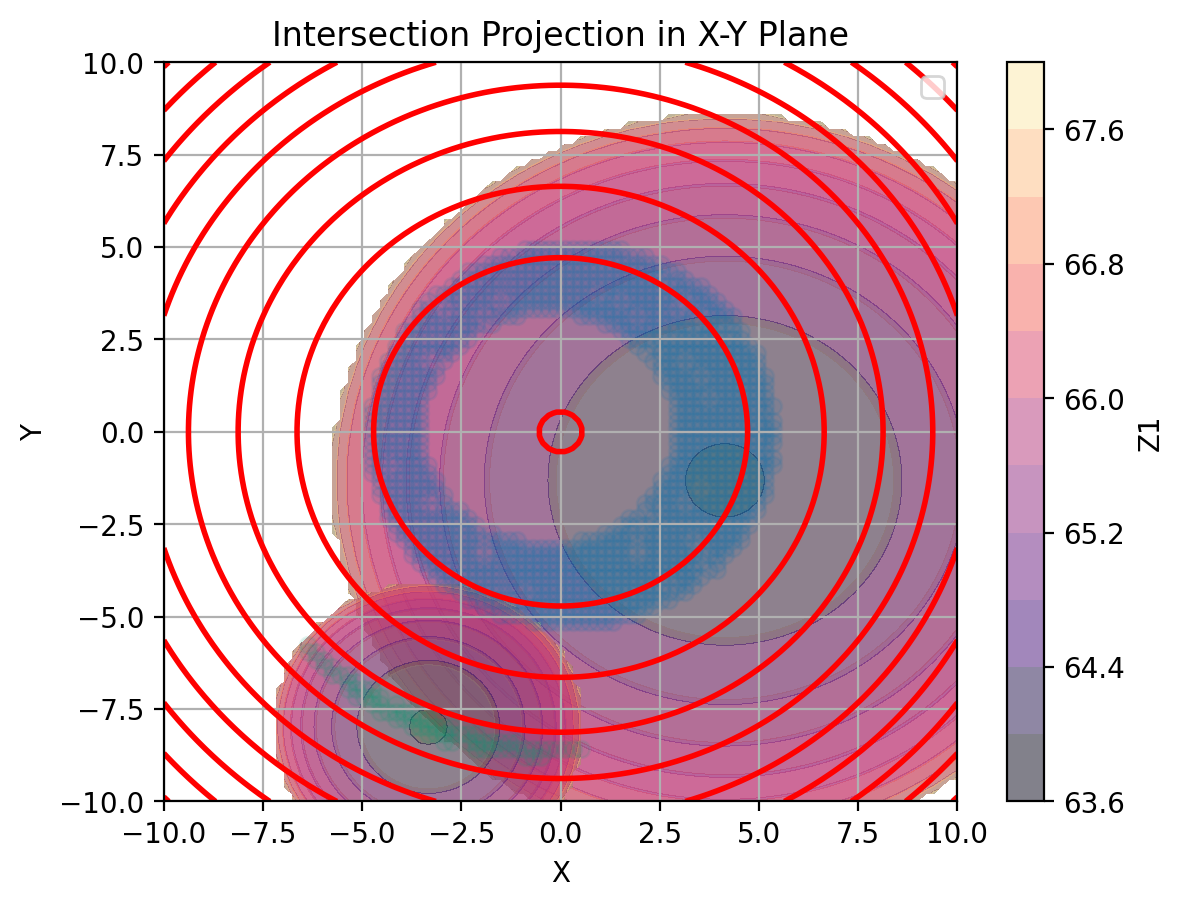

In [49]:
# Create a contour plot in the X-Y plane (Z=0)
plt.figure()
plt.contourf(x_p, y_p, z_e0, levels = 10, cmap='magma', alpha=0.5)
plt.contourf(x_p, y_p, z_e02, levels = 10, cmap='magma', alpha=0.5)

plt.contourf(x_p, y_p, z_e1, levels = 10, cmap='magma', alpha=0.5)
plt.contourf(x_p, y_p, z_e12, levels = 10, cmap='magma', alpha=0.5)

plt.colorbar(label='Z1')
plt.contour(x_p, y_p, z_p, levels = 10, colors='red', linewidths=2, label='Intersection')
plt.scatter(x_inter_1, y_inter_1, alpha = 0.1)
plt.scatter(x_inter_2, y_inter_2, alpha = 0.1)


plt.xlabel('X')
plt.ylabel('Y')
plt.title('Intersection Projection in X-Y Plane')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [50]:
x_inter_1.shape

(1261,)

In [51]:
x_inter = np.concatenate((x_inter_1, x_inter_2))
y_inter = np.concatenate((y_inter_1, y_inter_2))

In [52]:
new_xs_1 = np.arctan(x_inter_1 / vc.d) * (180 / np.pi) * 3600
new_ys_1 = np.arctan(y_inter_1 / vc.d) * (180 / np.pi) * 3600

In [53]:
new_xs_2 = np.arctan(x_inter_2 / vc.d) * (180 / np.pi) * 3600
new_ys_2 = np.arctan(y_inter_2 / vc.d) * (180 / np.pi) * 3600

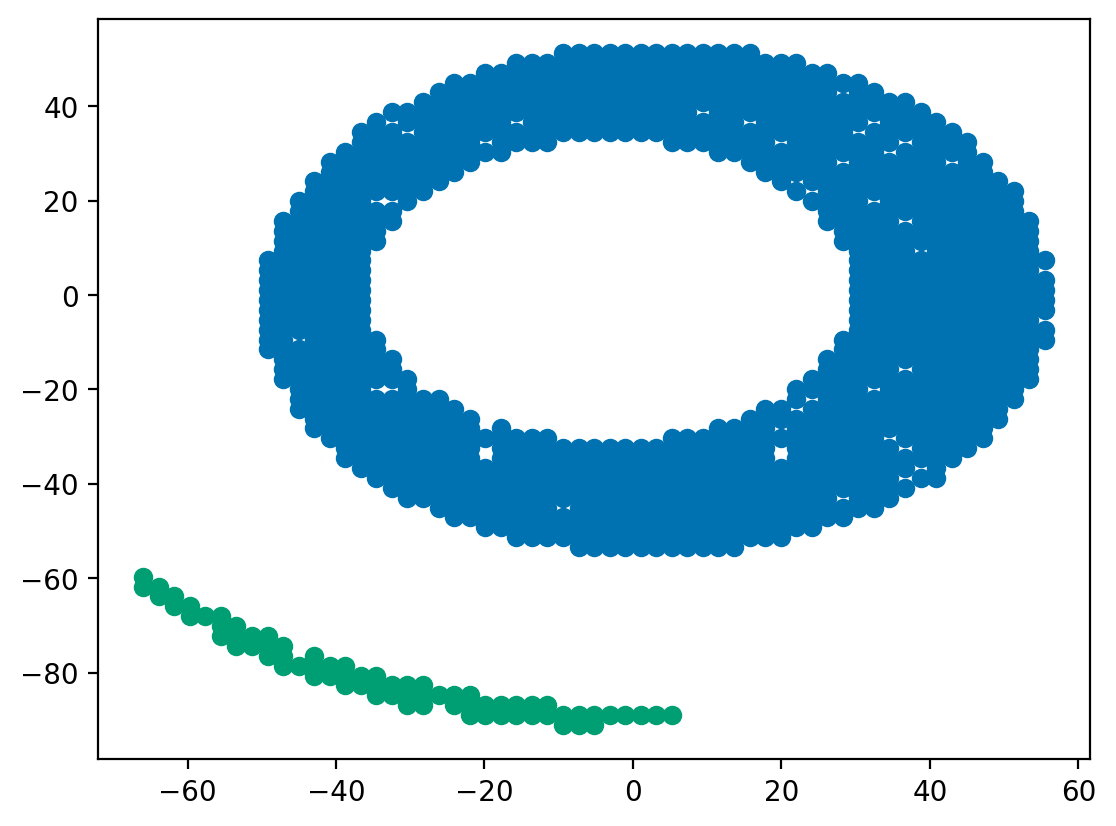

In [54]:
plt.scatter(new_xs_1, new_ys_1)
plt.scatter(new_xs_2, new_ys_2)

In [55]:

dz0 = np.abs(z_inter_1.min()-z_inter_1.max())
surface_1 = surface_brightness(x_inter_1, y_inter_1, z_inter_1, dz0)
dz0 = np.abs(z_inter_2.min()-z_inter_2.max())
surface_2 = surface_brightness(x_inter_2, y_inter_2, z_inter_2, dz0)

surface = np.concatenate((surface_1, surface_2))

[6.417036604449042e+21]
[6.417012360739329e+21]
[6.416995953451494e+21]
[6.416987675024153e+21]
[6.416987675024153e+21]
[6.416995953451494e+21]
[6.417012360739329e+21]
[6.417036604449042e+21]
[6.417068262107568e+21]
[6.417106799153588e+21]
[6.417151590609724e+21]
[6.417012360739329e+21]
[6.416954052023738e+21]
[6.416902036980782e+21]
[6.416857173091037e+21]
[6.416820240302808e+21]
[6.416791909323017e+21]
[6.416772712472778e+21]
[6.416763019356387e+21]
[6.416763019356387e+21]
[6.416772712472778e+21]
[6.416791909323017e+21]
[6.416820240302808e+21]
[6.416857173091037e+21]
[6.416902036980782e+21]
[6.416954052023738e+21]
[6.417012360739329e+21]
[6.417076060166597e+21]
[6.417144232289572e+21]
[6.416954052023738e+21]
[6.416875288964248e+21]
[6.416801414286233e+21]
[6.416733553694441e+21]
[6.416672825053491e+21]
[6.416620298907898e+21]
[6.41657695610125e+21]
[6.416543645208006e+21]
[6.416521042934686e+21]
[6.416509620756207e+21]
[6.416509620756207e+21]
[6.416521042934686e+21]
[6.41654364520800

(array([ 72.,   0., 188., 377., 260., 177., 135.,  61.,  45.,  18.]),
 array([1.40547967e+49, 5.37570250e+49, 9.34592532e+49, 1.33161481e+50,
        1.72863710e+50, 2.12565938e+50, 2.52268166e+50, 2.91970394e+50,
        3.31672623e+50, 3.71374851e+50, 4.11077079e+50]),
 <BarContainer object of 10 artists>)

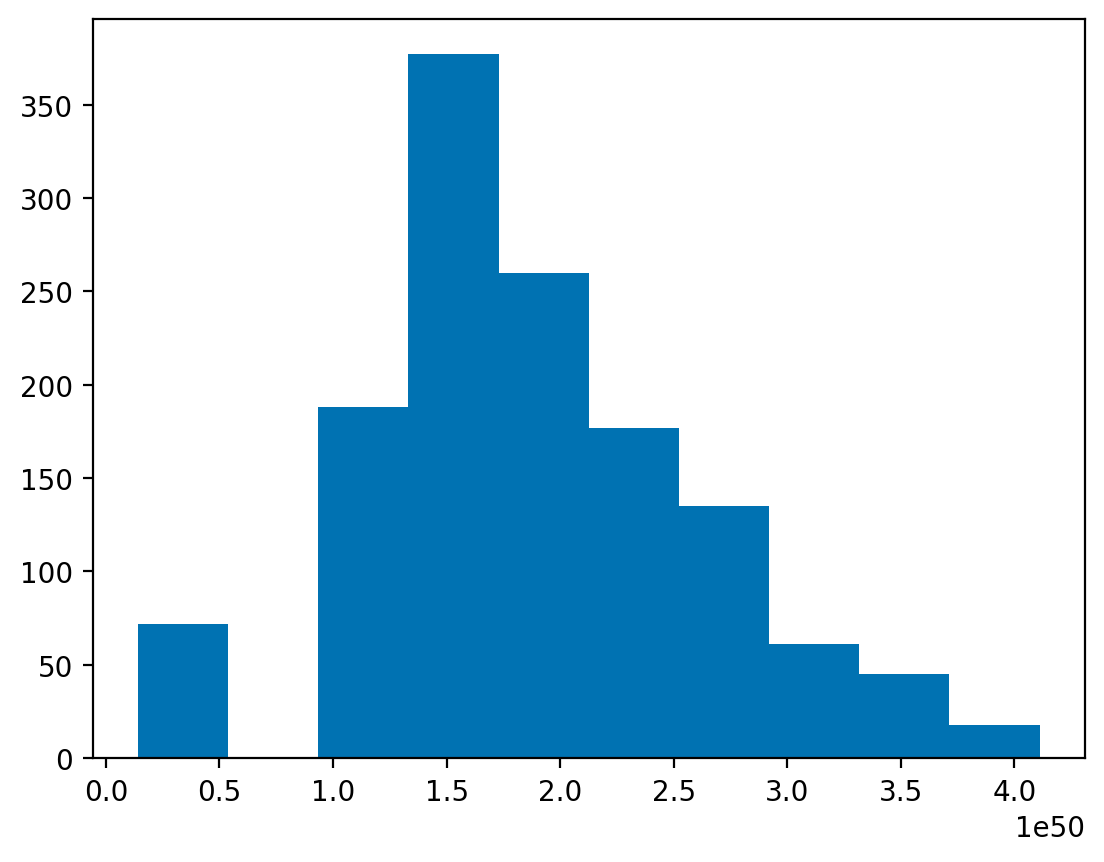

In [58]:
plt.hist(surface)

In [66]:
surface.max()

4.110770791755099e+50

In [70]:
fmax = 1.25*vc.L*0.5*vc.dt0
fmax

3.405331149352814e+30

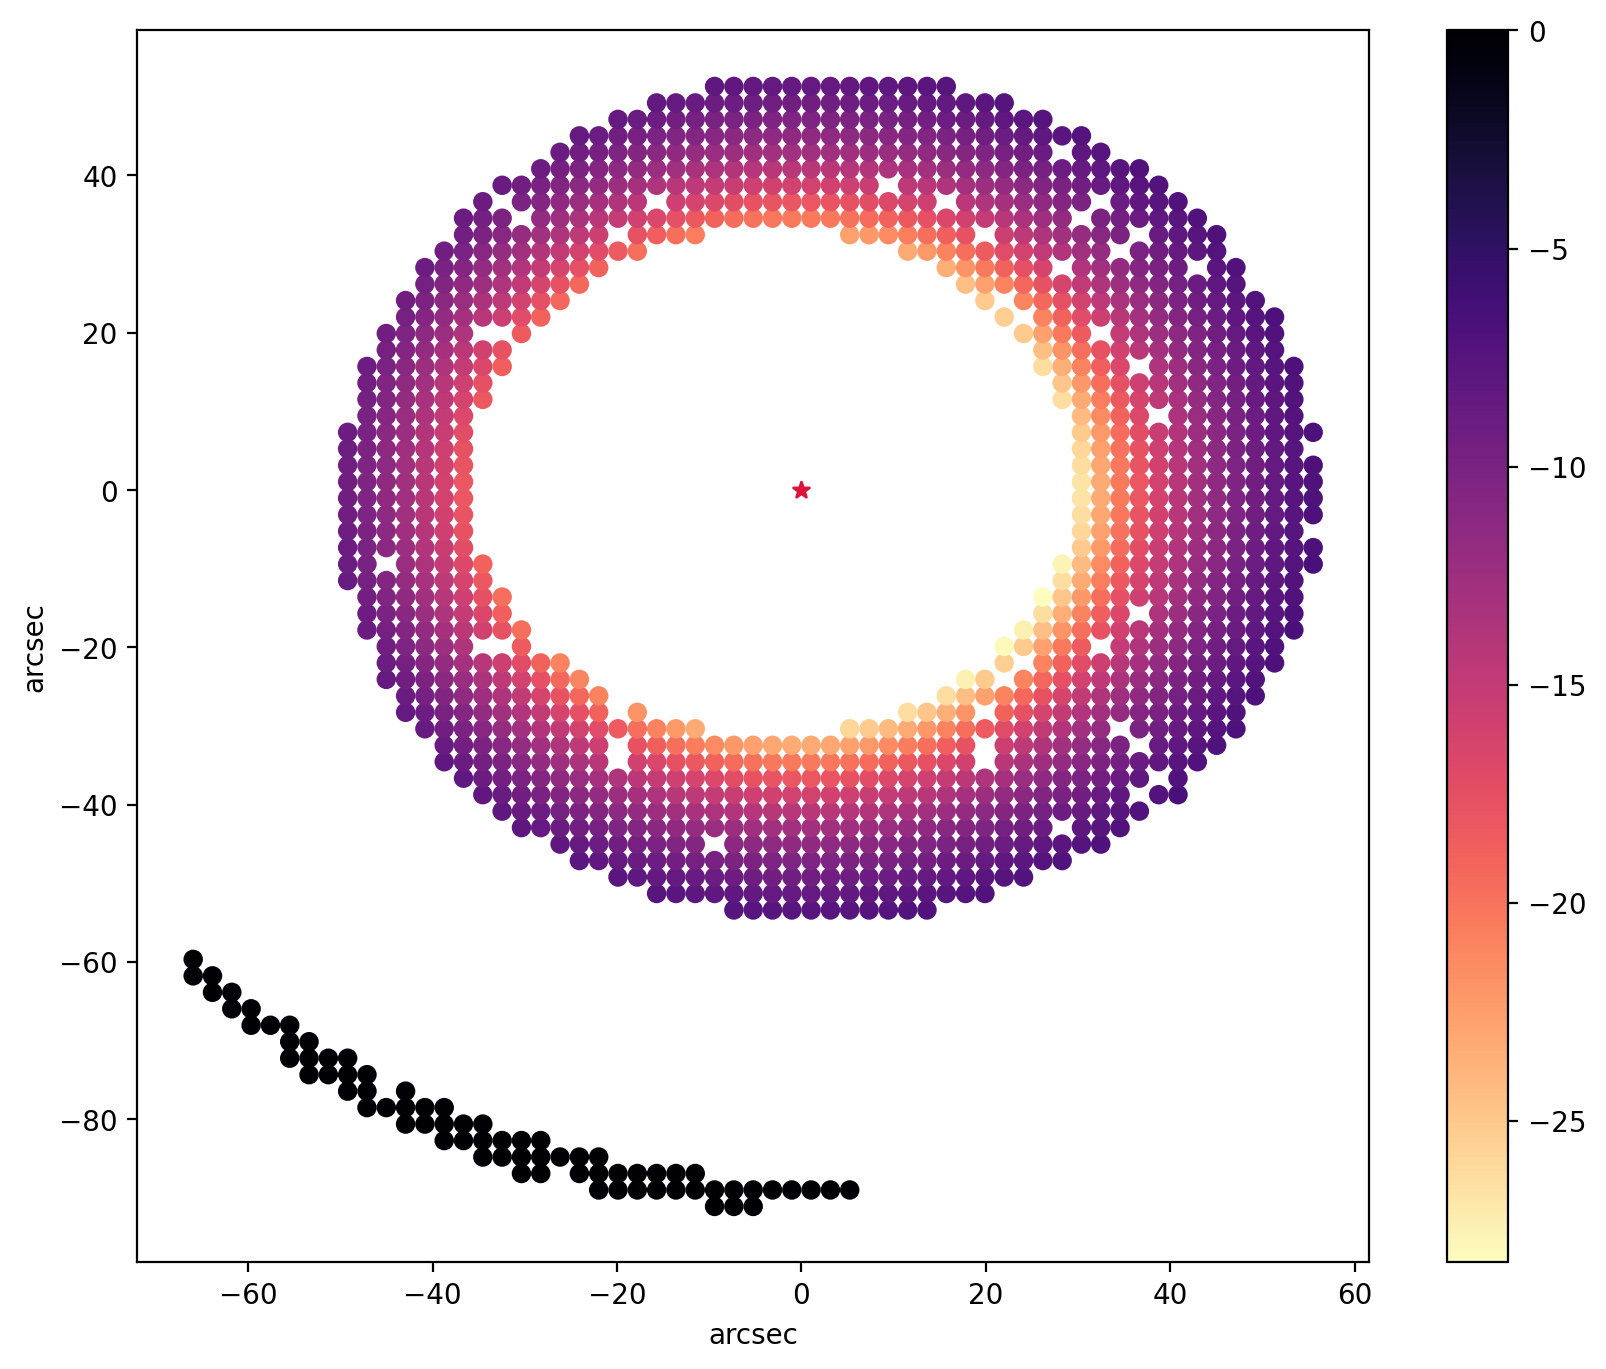

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / ( fmax - np.nanmin(surface.copy()))
# cmap = matplotlib.colormaps.get_cmap('magma_r')
# normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
ax.scatter(0, 0, marker = "*", color = "crimson")
new_xs = np.arctan(x_inter / vc.d) * (180 / np.pi) * 3600
new_ys = np.arctan(y_inter / vc.d) * (180 / np.pi) * 3600
cbarr = ax.scatter(new_xs, new_ys, c=surface_300_norm, cmap = "magma_r")

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)
plt.colorbar(cbarr)

In [ ]:
# data_cube_1 = dust(x_inter_1, n_h = n)
# data_cube_2 = dust(x_inter_2, n_h = n**(1/4))

# dz0 = np.abs(z_inter_1.min()-z_inter_1.max())
# surface_1 = surface_brightness(x_inter_1, y_inter_1, z_inter_1, ct, data_cube_1, Ir, dz0, dt0, d, g = 0)
# dz0 = np.abs(z_inter_2.min()-z_inter_2.max())
# surface_2 = surface_brightness(x_inter_2, y_inter_2, z_inter_2, ct, data_cube_1, Ir, dz0, dt0, d, g = 0.4)

# surface = np.concatenate((surface_1, surface_2))

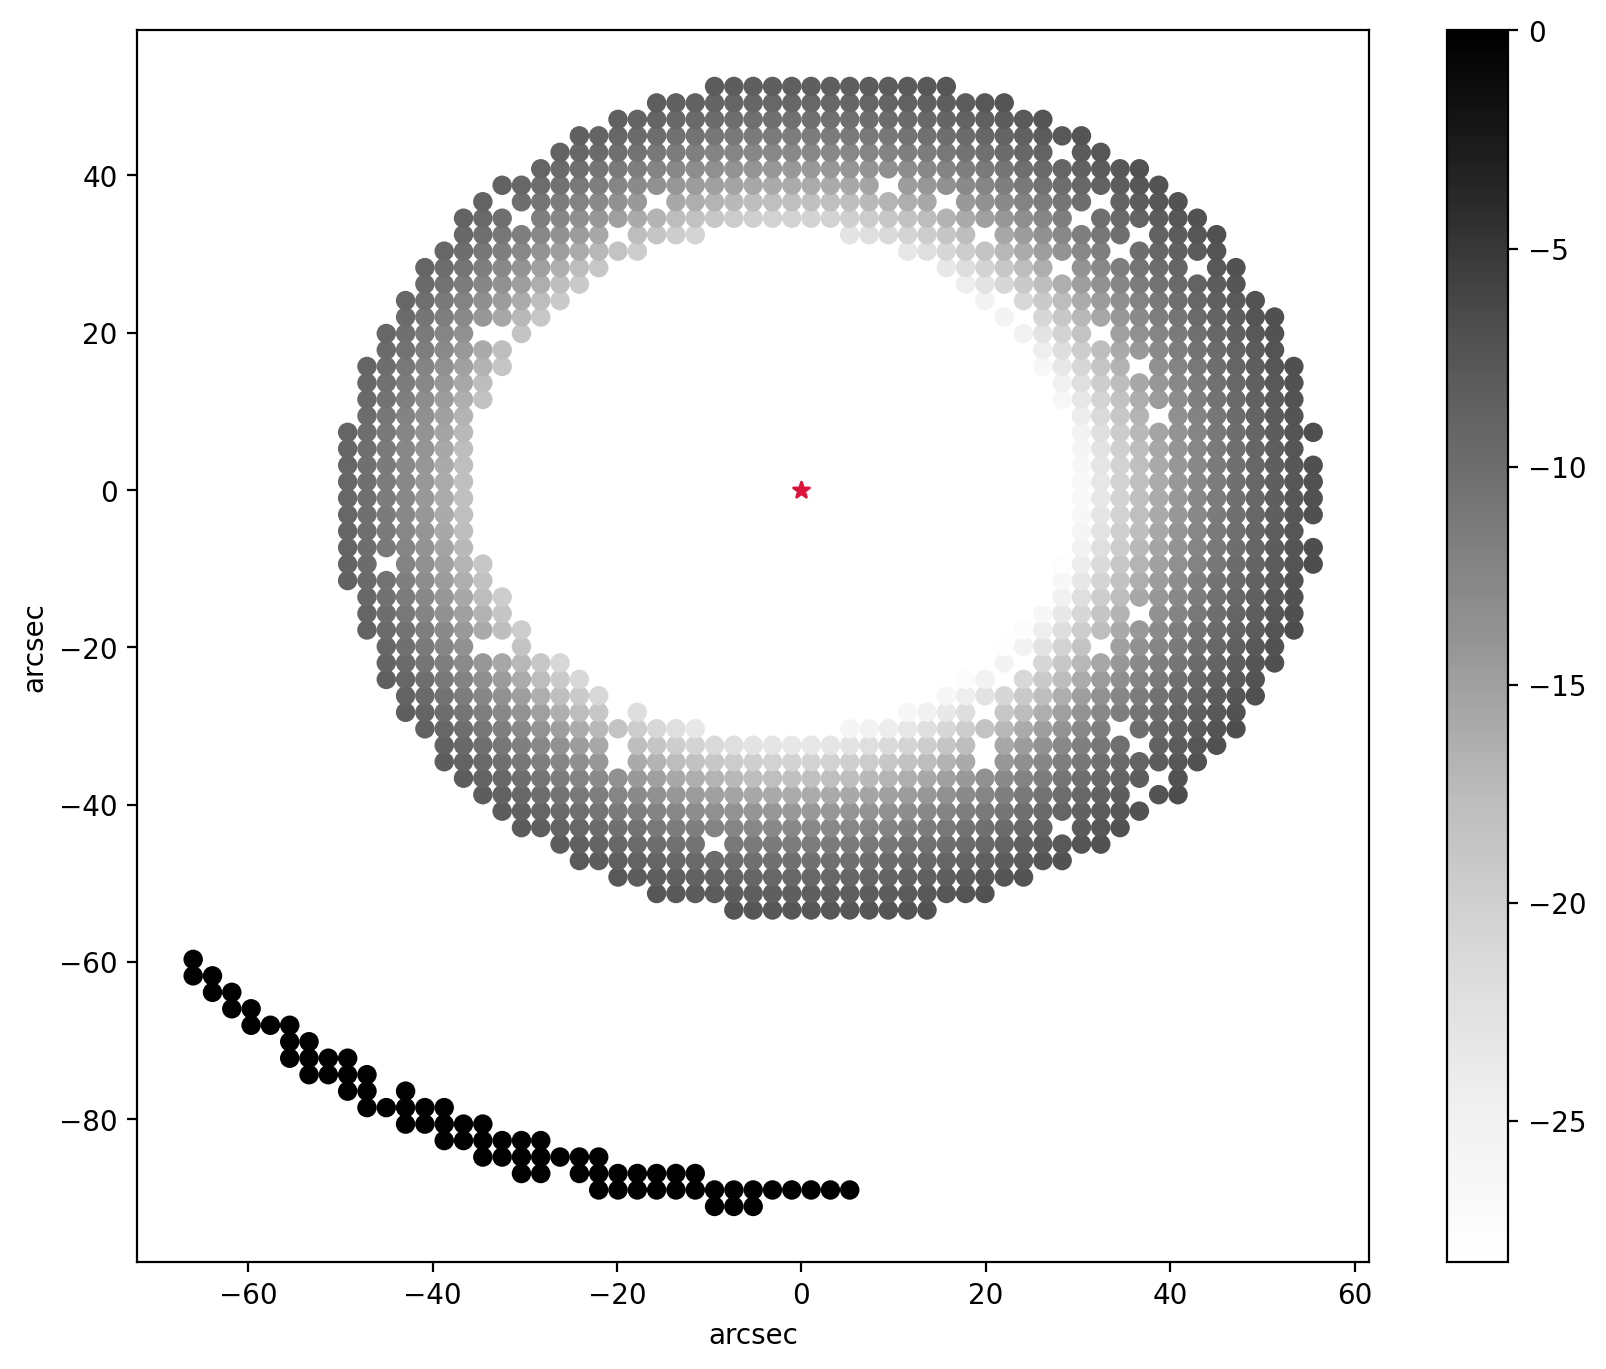

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
# cmap = matplotlib.colormaps.get_cmap('magma_r')
# normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
ax.scatter(0, 0, marker = "*", color = "crimson")
new_xs = np.arctan(x_inter / vc.d) * (180 / np.pi) * 3600
new_ys = np.arctan(y_inter / vc.d) * (180 / np.pi) * 3600
cbarr = ax.scatter(new_xs, new_ys, c=surface_300_norm, cmap = "Greys")

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)
plt.colorbar(cbarr)